In [2]:
import casadi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scienceplots
plt.style.use(['science','ieee','high-vis','grid']) # ここでスタイルを設定する

### パラメータ設定

In [8]:
ρ = 1025.0  # 海水密度

# suzaku
nabla = 0.2358  # 排水量[m3] Lpp*B:d*Cb
L_pp = 3.50  # 船長Lpp[m]
B = 0.57  # 船幅[m]
d = 0.16  # 喫水[m]
x_G = 0.0112  # 重心位置[]
C_b = 0.7390 # 方形係数
D_p = 0.03373 * L_pp #0.120  # プロペラ直径[m]
m = 1025 * nabla  # 質量(無次元化)[kg]
A_R = 0.0189  # 船の断面に対する舵面積比[-]
# H_R = 0.1495  # 舵高さ[m]
η = 0.8023  # プロペラ直径に対する舵高さ(Dp/H)
m_x_dash = 0.0475 # 付加質量x(無次元) kg/m3 * m2 * m /kg
m_y_dash = 0.6739 # 付加質量y(無次元)
J_z_dash = 0.0306 # 付加質量Izz(無次元)
f_α = 2.634 # 直圧力勾配係数
ϵ = 1.345  # プロペラ・舵位置伴流係数比
t_R = 0.084  # 操縦抵抗減少率 
a_H = 0.054  # 舵力増加係数
x_H = -0.388 * L_pp  # 舵力増分作用位置
γ_R_minus = 0.225 # 整流係数
γ_R_plus = 0.574  # 整流係数
l_r_dash = -0.641  # 船長に対する舵位置
κ = 0.482  # 修正係数
t_P = 0.035  # 推力減少率 #モデルの違い
w_P0 = 0.397  # 有効伴流率 #モデルの違い
# t_P = 0.180  # 推力減少率 #モデルの違い
# w_P0 = 0.40  # 有効伴流率 #モデルの違い
x_P = -0.490  # 船長に対するプロペラ位置 #モデルの違い
x_R = -0.500 * L_pp
I_zG=ρ * nabla * ((0.25 * L_pp) ** 2)
m_x=(0.5 * ρ * (L_pp ** 2) * d) * m_x_dash  # 付加質量x(無次元)
m_y=(0.5 * ρ * (L_pp ** 2) * d) * m_y_dash  # 付加質量y(無次元)
J_z=(0.5 * ρ * (L_pp ** 4) * d) * J_z_dash  # 付加質量Izz(無次元)

In [3]:
k_0 = 0.3516
k_1 = -0.3624
k_2 = -0.1100
R_0_dash = 0.020
X_vv_dash = -0.07993
X_vr_dash = 0.10163
X_rr_dash = -0.01487
X_vvvv_dash = 0.57037
Y_v_dash = -0.37112
Y_r_dash = 0.07203
# Y_v_dash = -0.3384 #-0.37112
# Y_r_dash = 0.1976 #0.07203
Y_vvv_dash = -1.05345
Y_vvr_dash = 0.20726
Y_vrr_dash = -0.25560
Y_rrr_dash = 0.02196
N_v_dash = -0.10969
N_r_dash = -0.04994
# N_v_dash = -0.1377 #-0.10969
# N_r_dash = -0.0992#-0.04994
N_vvv_dash = -0.05329
N_vvr_dash = -0.28770
N_vrr_dash = -0.02059
N_rrr_dash = -0.01959

In [4]:
def X_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*X_H_dash(v_dash,r_dash)

def Y_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp*d*U**2*Y_H_dash(v_dash,r_dash)

def N_H(u,v,r):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/u)
    r_dash=r*L_pp/U
    v_dash=v/U
    return 0.5*ρ*L_pp**2*d*U**2*N_H_dash(v_dash,r_dash)

def X_H_dash(β,r_dash):
    return -R_0_dash+X_vv_dash*β**2+X_vr_dash*β*r_dash+X_rr_dash*r_dash**2+X_vvvv_dash*β**4

def Y_H_dash(β,r_dash):
    return Y_v_dash*β+Y_r_dash*r_dash+Y_vvr_dash*β**2*r_dash+Y_vrr_dash*β*r_dash**2+Y_vvv_dash*β**3+Y_rrr_dash*r_dash**3

def N_H_dash(β,r_dash):
    return N_v_dash*β+N_r_dash*r_dash+N_vvr_dash*β**2*r_dash+N_vrr_dash*β*r_dash**2+N_vvv_dash*β**3+N_rrr_dash*r_dash**3

def X_R(u,v,r,δ,n_p):
    return -(1-t_R)*F_N(u,v,r,δ,n_p)*np.sin(δ)

def Y_R(u,v,r,δ,n_p):
    return -(1+a_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def N_R(u,v,r,δ,n_p):
    return -(x_R+a_H*x_H)*F_N(u,v,r,δ,n_p)*np.cos(δ)

def F_N(u,v,r,δ,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    u_p=(1-w_P)*u
    u_R=ϵ*u_p*np.sqrt(η*(1+κ*(np.sqrt(1+(8*K_T(u,v,r,n_p))/(np.pi*J(u,v,r,n_p)**2))-1))**2+(1-η))
    v_R=U*γ_R_plus*(β-l_r_dash*r_dash)
    α_R=δ-np.arctan(v_R/u_R)
    U_R=np.sqrt(u_R**2+v_R**2)
    return 0.5*ρ*A_R*U_R**2*f_α*np.sin(α_R)

def X_P(u,v,r,δ,n_p):
    return (1-t_P)*T_P(u,v,r,n_p)

def K_T(u,v,r,n_p):
    return k_0+k_1*J(u,v,r,n_p)+k_2*J(u,v,r,n_p)**2

def J(u,v,r,n_p):
    U=np.sqrt(u**2+v**2)
    β=np.arctan(-v/U)
    r_dash=r*L_pp/U
    w_P = w_P0 * np.exp(-4.0 * (β - x_P * r_dash) ** 2)
    return u*(1-w_P)/(n_p*D_p)

def T_P(u,v,r,n_p):
    return K_T(u,v,r,n_p)*ρ*n_p**2*D_p**4

In [3]:
# 目標軌道の設定
obs = pd.read_csv('observation/suzaku_obs.csv')
# obs = pd.read_csv('observation/suzaku_0ef_20deg 2.csv')
# obs = pd.read_csv('observation/suzaku_z_obs.csv')
obs

,Unnamed: 0,time_list,u,v,r,x,y,psi,δ,npm,...,X_R_ref,X_P_ref,Y_H_ref,Y_R_ref,N_H_ref,N_R_ref,x_bow,y_bow,x_stern,y_stern
0,0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.349066,9,...,-6.012895,-3.135306,0.000000,-16.520294,-0.000000,32.884258,1.750000,0.000000,-1.750000,0.000000
1,1,1.005025,1.903657,-0.026705,0.043007,1.960545,0.003549,0.023846,0.349066,9,...,-4.846691,-2.693952,11.380447,-13.316174,-8.818393,26.506338,3.710047,0.045276,0.211042,-0.038177
2,2,2.010050,1.812678,-0.057914,0.068553,3.827938,0.054425,0.080796,0.349066,9,...,-4.053708,-2.373095,20.424739,-11.137472,-10.490794,22.169551,5.572229,0.195665,2.083647,-0.086814
3,3,3.015075,1.714731,-0.088152,0.086514,5.597427,0.190315,0.159161,0.349066,9,...,-3.411274,-2.065349,27.518981,-9.372399,-9.999576,18.656107,7.325309,0.467672,3.869546,-0.087041
4,4,4.020101,1.607831,-0.115201,0.100114,7.253238,0.429203,0.253232,0.349066,9,...,-2.858301,-1.740376,32.727268,-7.853119,-9.000267,15.631924,8.947427,0.867638,5.559050,-0.009232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195.979899,0.247952,-0.056908,0.073076,21.518458,9.746036,12.406982,0.349066,9,...,-0.644075,4.136669,4.788475,-1.769582,-3.562374,3.522418,23.246276,9.468286,19.790640,10.023786
196,196,196.984925,0.254217,-0.059156,0.073066,21.761367,9.657647,12.480297,0.349066,9,...,-0.645365,4.105060,4.960073,-1.773125,-3.549658,3.529471,23.504888,9.507203,20.017845,9.808090
197,197,197.989950,0.254893,-0.061513,0.073033,22.013194,9.584502,12.553751,0.349066,9,...,-0.640113,4.098591,5.117966,-1.758696,-3.539670,3.500749,23.763055,9.562419,20.263334,9.606586
198,198,198.994975,0.250258,-0.063908,0.072926,22.269423,9.527262,12.627273,0.349066,9,...,-0.628977,4.116829,5.255605,-1.728100,-3.533718,3.439848,24.016179,9.633776,20.522668,9.420749


(-3.0, 3.0)

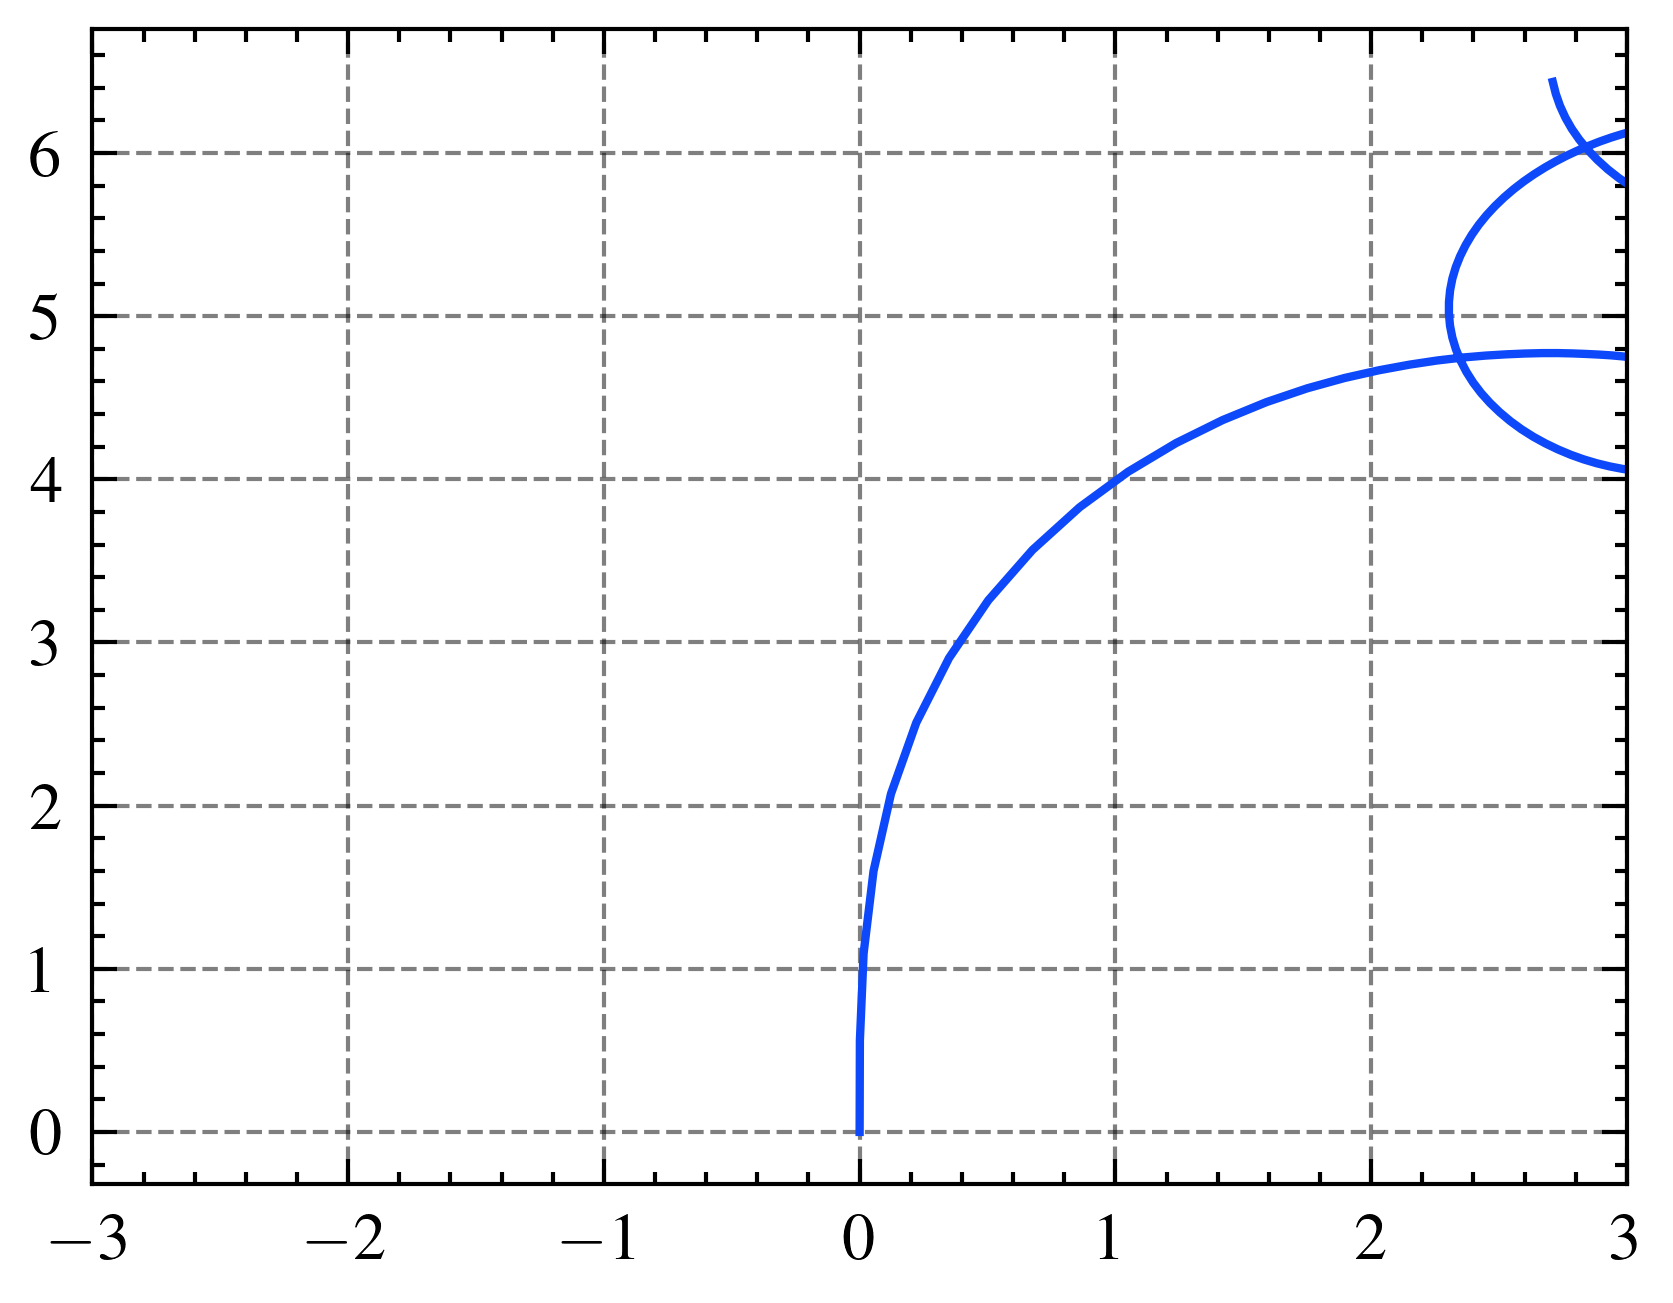

In [6]:
plt.plot(obs['y']/L_pp, obs['x']/L_pp)
plt.xlim(-3,3)

In [6]:
# 評価関数の重み
Q = casadi.diag([1,1,1,1]) # 状態変数の重み
Q_f = casadi.diag([1,1,1,1])
R = casadi.diag([1e-6,1e-6,1e-7]) # 制御入力の重み

# ホライゾン
K = 50
T = 130
dt = 1

# 制約条件
x_lb = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
x_ub = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
u_lb = [-10, -10, -10]
u_ub = [10, 10, 10]

nx = 11 # 状態変数の次元
nu = 3 # 制御入力の次元

# 目標値
x_ref = casadi.DM(obs[['x_bow', 'y_bow', 'x_stern', 'y_stern']].values)
# u_ref = casadi.DM() 設定しない

# 最適化に現れる全ての変数の次元の合計
total = nx*(K+1) + nu*K

### 状態方程式の設定

In [8]:
# states:u,v,r,x1,y1,x2,y2,psi,δ,np
# ctrls:xf,yf,nf

In [9]:
def make_f(start=None,end=None,k=None,t=None):
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)
    # 状態変数
    u = states[0]
    v = states[1]
    r = states[2]
    x_bow = states[3]
    y_bow = states[4]
    x_stern = states[5]
    y_stern = states[6]
    psi = states[7]
    X_F_m = states[8]
    Y_F_m = states[9]
    N_F_m = states[10]

    if t is not None:
        δ = obs['δ'][t]
        np = obs['npm'][t]
    else:
        δ = obs['δ'][start:end][start+k]
        np = obs['npm'][start:end][start+k]
    # δ = obs['δ'][0]
    # np = obs['npm'][0]
    # 制御入力
    X_F = ctrls[0]
    Y_F = ctrls[1]
    N_F = ctrls[2]
    
    u_dot = (X_H(u,v,r)+X_R(u,v,r,δ,np)+X_P(u,v,r,δ,np)+X_F+(m+m_y)*v*r)/(m+m_x)
    v_dot = (Y_H(u,v,r)+Y_R(u,v,r,δ,np)+Y_F-(m+m_x)*u*r)/(m+m_y)
    r_dot = (N_H(u,v,r)+N_R(u,v,r,δ,np)+N_F)/(I_zG+J_z)
    x_bow_dot = u*casadi.cos(psi)-v*casadi.sin(psi)-0.5*L_pp*r*casadi.sin(psi)
    y_bow_dot = u*casadi.sin(psi)+v*casadi.cos(psi)+0.5*L_pp*r*casadi.cos(psi)
    x_stern_dot = u*casadi.cos(psi)-v*casadi.sin(psi)+0.5*L_pp*r*casadi.sin(psi)
    y_stern_dot = u*casadi.sin(psi)+v*casadi.cos(psi)-0.5*L_pp*r*casadi.cos(psi)
    psi_dot = r
    X_F_m_dot = X_F - X_F_m
    Y_F_m_dot = Y_F - Y_F_m
    N_F_m_dot = N_F - N_F_m
    
    states_dot = casadi.vertcat(u_dot, v_dot, r_dot, x_bow_dot, y_bow_dot, x_stern_dot, y_stern_dot, psi_dot, X_F_m_dot, Y_F_m_dot, N_F_m_dot)
    
    f = casadi.Function('f',[states,ctrls],[states_dot],
                        ['x','u'],['x_dot'])
    return f

In [10]:
obs.keys()

Index(['Unnamed: 0', 'time_list', 'u', 'v', 'r', 'x', 'y', 'psi', 'δ', 'npm',
       'X_H_ref', 'X_R_ref', 'X_P_ref', 'Y_H_ref', 'Y_R_ref', 'N_H_ref',
       'N_R_ref', 'x_bow', 'y_bow', 'x_stern', 'y_stern'],
      dtype='object')

### 連続時間状態方程式の時間離散化

In [11]:
def make_RK4(start,end,k):
    states = casadi.SX.sym('states',nx) # nxの数を設定
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(start=start,end=end,k=k)
    
    r1 = f(x=states,u=ctrls)['x_dot']
    r2 = f(x=states+dt*r1/2,u=ctrls)['x_dot']
    r3 = f(x=states+dt*r2/2,u=ctrls)['x_dot']
    r4 = f(x=states+dt*r3,u=ctrls)['x_dot']
    
    states_next = states + dt*(r1+2*r2+2*r3+r4)/6
    
    RK4 = casadi.Function('RK4',[states,ctrls],[states_next],
                          ['x','u'],['x_next'])
    return RK4

### 積分器の作成

In [12]:
def make_integrator(t):
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)
    
    f = make_f(t=t)
    ode = f(x=states,u=ctrls)['x_dot']
    
    dae = {'x':states,'p':ctrls,'ode':ode}
    
    I = casadi.integrator('I','cvodes',dae,0,dt)
    return I

In [13]:
# I = make_integrator()
# x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0]])
# u_init = casadi.DM([0,0,0])
# X = [x_init]
# x_current = x_init
# for t in range(130):
#     x_current = I(x0=x_current,p=u_init)['xf']
#     X.append(x_current)
# X.pop()
# X=np.array(X).reshape(130,8)
# fig=plt.figure(figsize=(8.0,8.0))
# plt.plot((X[:,4]+X[:,6])/2,(X[:,3]+X[:,5])/2,c = 'r')
# plt.plot(obs20['y'][0:130],obs20['x'][0:130],c = 'b')

### 評価関数

In [14]:
def compute_stage_cost(x,u,x_ref_slice,k):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref_slice[k,:].T
    u_diff = u
    # cost = (casadi.dot(Q@x_diff,x_diff)) / 2
    cost = (casadi.dot(Q@x_diff,x_diff)
            + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_terminal_cost(x,x_ref_slice):
    x_extract = x[3:7]
    x_diff = x_extract - x_ref_slice[-1,:].T
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [15]:
def make_nlp(x_ref_slice,start,end):
    # RK4 = make_RK4(start,end,t)
    U = [casadi.SX.sym(f'u_{k}',nu) for k in range(K)]
    X = [casadi.SX.sym(f'x_{k}',nx) for k in range(K+1)]
    G = []
    
    J = 0
    
    for k in range(K):
        RK4 = make_RK4(start,end,k)
        J += compute_stage_cost(X[k],U[k],x_ref_slice,k)*dt #評価関数はC
        eq = X[k+1] - RK4(x=X[k],u=U[k])['x_next']
        G.append(eq) # 制約条件を追加
    J += compute_terminal_cost(X[-1],x_ref_slice)
    
    option = {'print_time':False,
              'ipopt':{'max_iter':500,'print_level':0}}
    nlp = {'x':casadi.vertcat(*X,*U),'f':J,'g':casadi.vertcat(*G)}
    # S = casadi.nlpsol('S','ipopt',nlp)
    S = casadi.nlpsol('S','ipopt',nlp,option)
    return S

### 最適な制御入力を出力する関数

In [16]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K
    
    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res['x']
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

### MPCの実行

In [17]:
t_span = [0,130]
t_eval = np.arange(*t_span,dt)
# 初期値設定
if obs['u'][0]==obs['v'][0]==obs['r'][0]==0:
    x_init = casadi.DM([0.001,0.001,0.001,obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0], 0, 0, 0])
else:
    x_init = casadi.DM([obs['u'][0],obs['v'][0],obs['r'][0],obs['x_bow'][0], obs['y_bow'][0], obs['x_stern'][0], obs['y_stern'][0],obs['psi'][0], 0, 0, 0])
x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K),casadi.DM([0,0,0]),casadi.DM.ones(nu*(K-1)))
# x0 = casadi.vertcat(x_init,casadi.DM.ones(nx*K),casadi.DM.ones(nu*K))


X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    # tに応じて目標のスライスを決定
    start = int(t/dt)
    end = start + K
    x_ref_slice = x_ref[start:end,:]
    
    S = make_nlp(x_ref_slice,start,end)
    I = make_integrator(t)
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)['xf']
    X.append(x_current)
    U.append(u_opt)
    
X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



### 結果の可視化

(-3.0, 3.0)

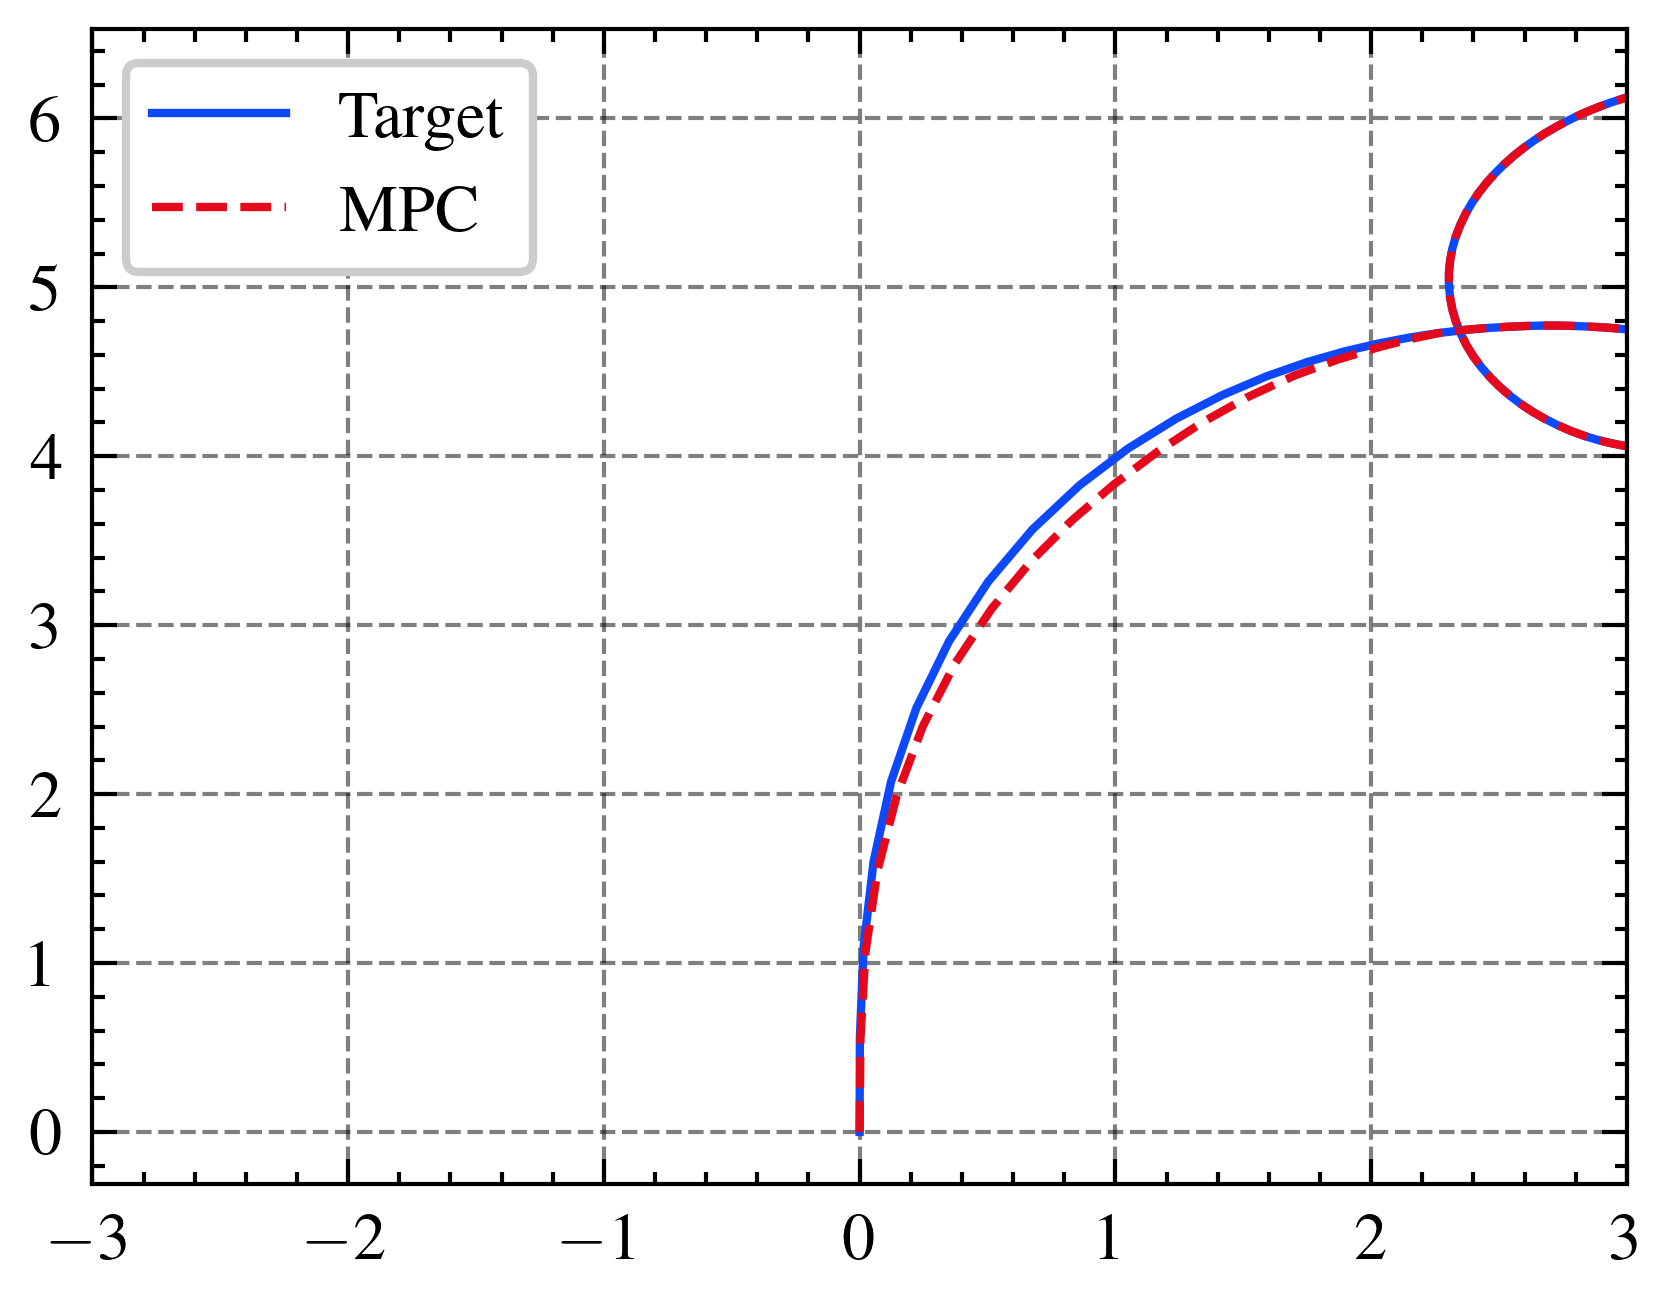

In [18]:
u_ref, v_ref, r_ref, x_bow_ref, y_bow_ref, x_stern_ref, y_stern_ref, psi_ref = obs[['u', 'v', 'r', 'x_bow', 'y_bow', 'x_stern', 'y_stern', 'psi']][0:int(T/dt)].values.T
u, v, r, x_bow, y_bow, x_stern, y_stern, psi, X_F_Body, Y_F_Body, N_F_Body  = X.T
X_F, Y_F, N_F = U.T
plt.plot(((y_bow_ref+y_stern_ref)/2)/L_pp, ((x_bow_ref+x_stern_ref)/2)/L_pp, label='Target')
plt.plot(((y_bow+y_stern)/2)/L_pp, ((x_bow+x_stern)/2)/L_pp, label='MPC')
plt.legend()
plt.xlim(-3,3)
# plt.plot(obs20['y'], obs20['x'], c='darkorange',linestyle='dashed')


### 空間固定座標系に変換

In [19]:
X_F_Earth = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) - Y_F * np.sin(psi)
        ,
        X_F_Body,
        Y_F_Body,
        psi,
    )
)
Y_F_Earth = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        X_F_Body,
        Y_F_Body,
        psi,
    )
)
N_F_Earth = N_F_Body

In [ ]:
X_F_Earth_target = 1.5 * np.sin(2*np.pi/5*t_eval) + 2.0
Y_F_Earth_target = np.ones(t_eval.size)*0.0

X_F_target = list(
    map(
        lambda X_F, Y_F, psi:
        X_F * np.cos(psi) + Y_F * np.sin(psi)
        ,
        X_F_Earth_target,
        Y_F_Earth_target,
        psi_ref
    )
)
Y_F_target = list(
    map(
        lambda X_F, Y_F, psi:
        -X_F * np.sin(psi) + Y_F * np.cos(psi)
        ,
        X_F_Earth_target,
        Y_F_Earth_target,
        psi_ref
    )
)
N_F_Earth_target = list(map(lambda y: y * np.abs(x_G), Y_F_target))

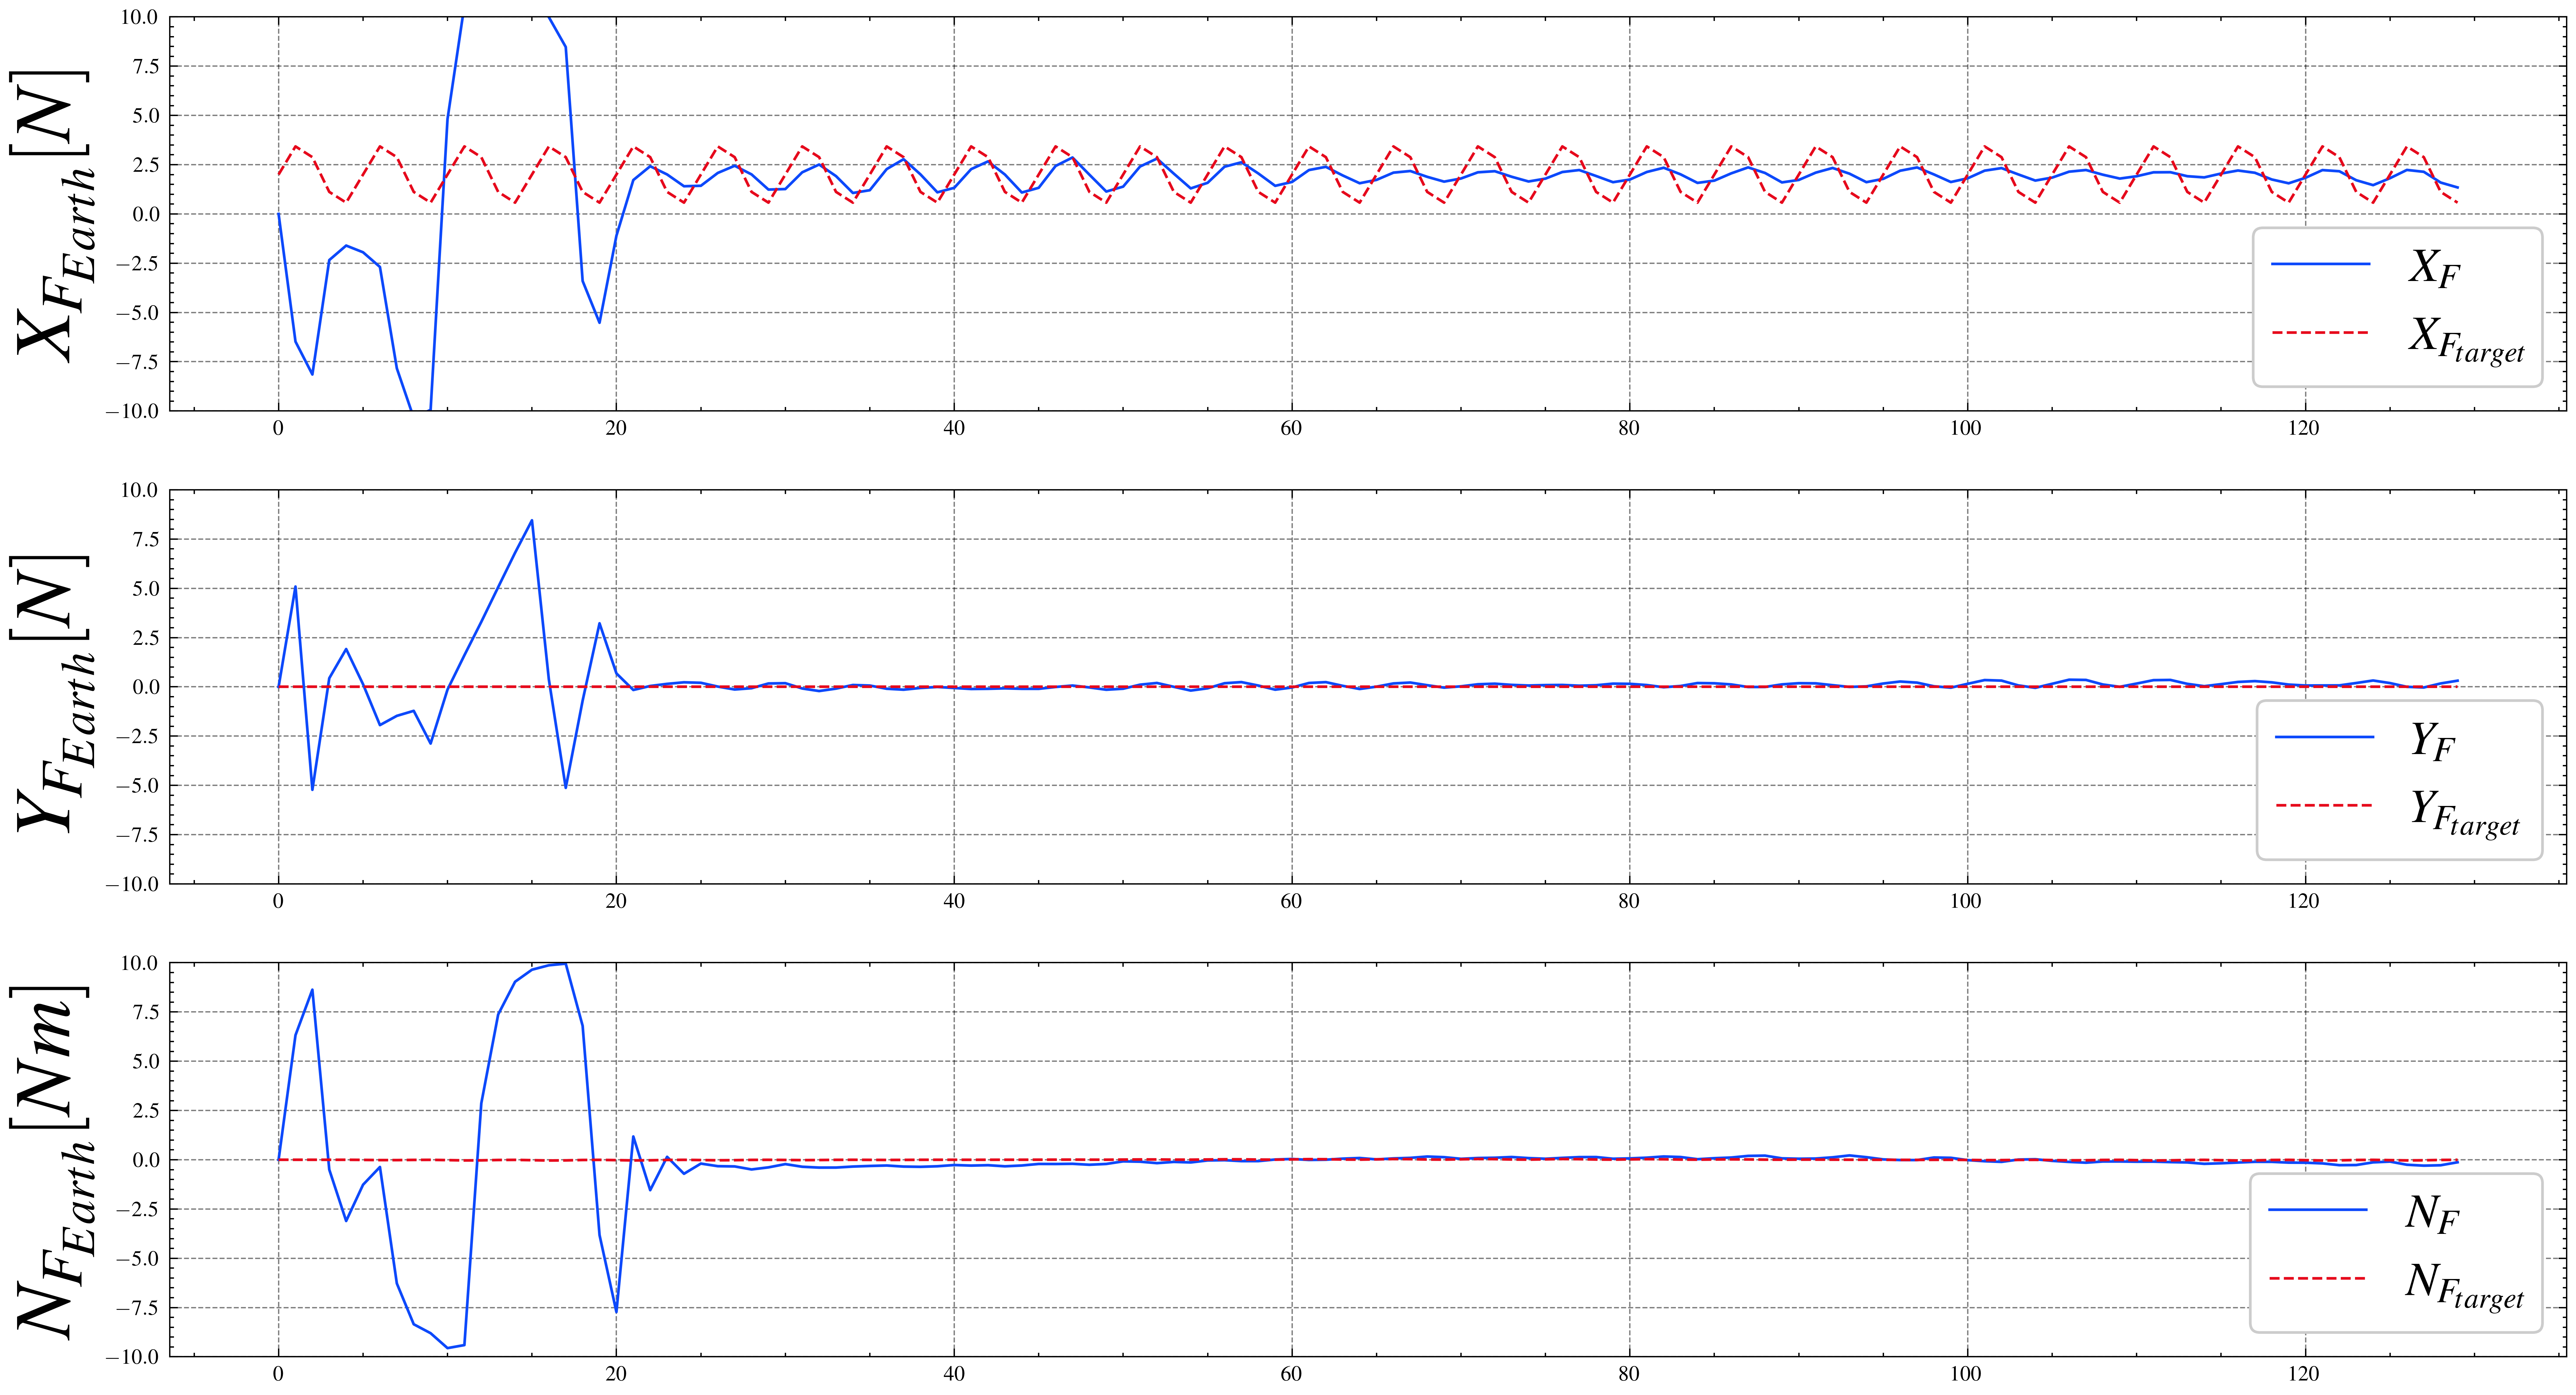

In [21]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(t_eval, X_F_Earth, label='$X_F$')
ax1.plot(t_eval, X_F_Earth_target, label='$X_{F_{target}}$')
ax1.set_ylabel('$X_{F_{Earth}}[N]$', fontsize=30)
ax1.set_ylim(-10, 10)
ax1.legend(frameon=True, loc='lower right', fontsize=18)

ax2 = fig.add_subplot(3,1,2)
ax2.plot(t_eval, Y_F_Earth, label='$Y_F$')
ax2.plot(t_eval, Y_F_Earth_target, label='$Y_{F_{target}}$')
ax2.set_ylabel('$Y_{F_{Earth}}[N]$', fontsize=30)
ax2.set_ylim(-10, 10)
ax2.legend(frameon=True, loc='lower right', fontsize=18)

ax3 = fig.add_subplot(3,1,3)
ax3.plot(t_eval, N_F_Earth, label='$N_F$')
ax3.plot(t_eval, N_F_Earth_target, label='$N_{F_{target}}$')
ax3.set_ylabel('$N_{F_{Earth}}[Nm]$', fontsize=30)
ax3.set_ylim(-10, 10)
ax3.legend(frameon=True, loc='lower right', fontsize=18)

In [ ]:
# df = pd.DataFrame({'time':t_eval, 'X_F_target':X_F_Earth_target, 'Y_F_target':Y_F_Earth_target, 'N_F_target':N_F_Earth_target, 'psi':psi_ref})
# df.to_csv('force_obs/suzaku_1.5EF20deg_force_target.csv')

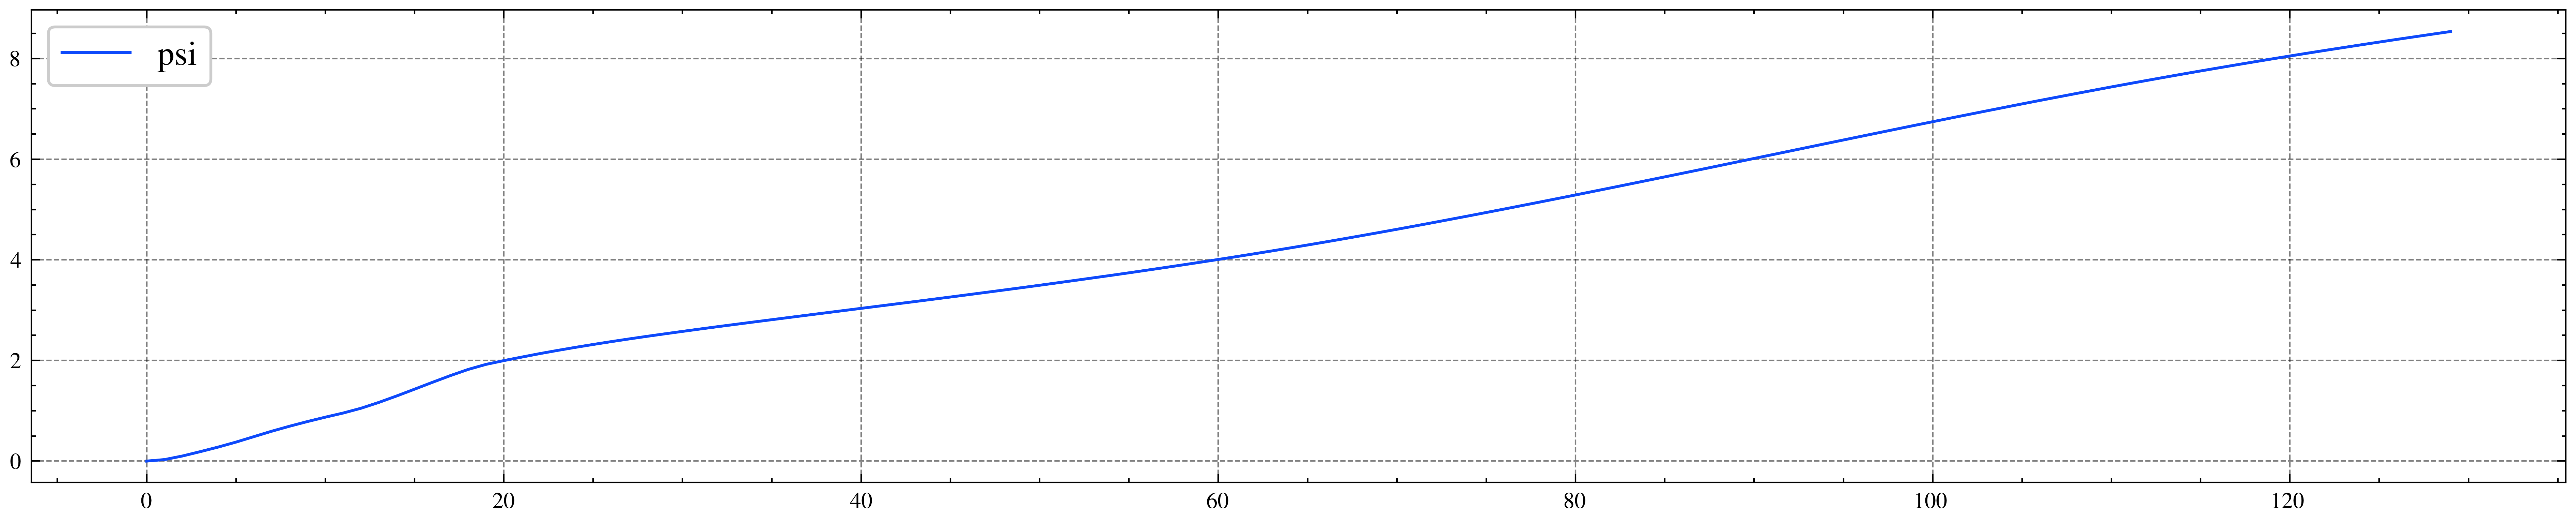

In [22]:
plt.figure(figsize=(16,3))
plt.plot(t_eval,psi,label='psi')
plt.legend(fontsize=12)

/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_15288/324881926.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/42/rycq9wgs5g3_yj8bjfwx0mkw0000gn/T/ipykernel_15288/324881926.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


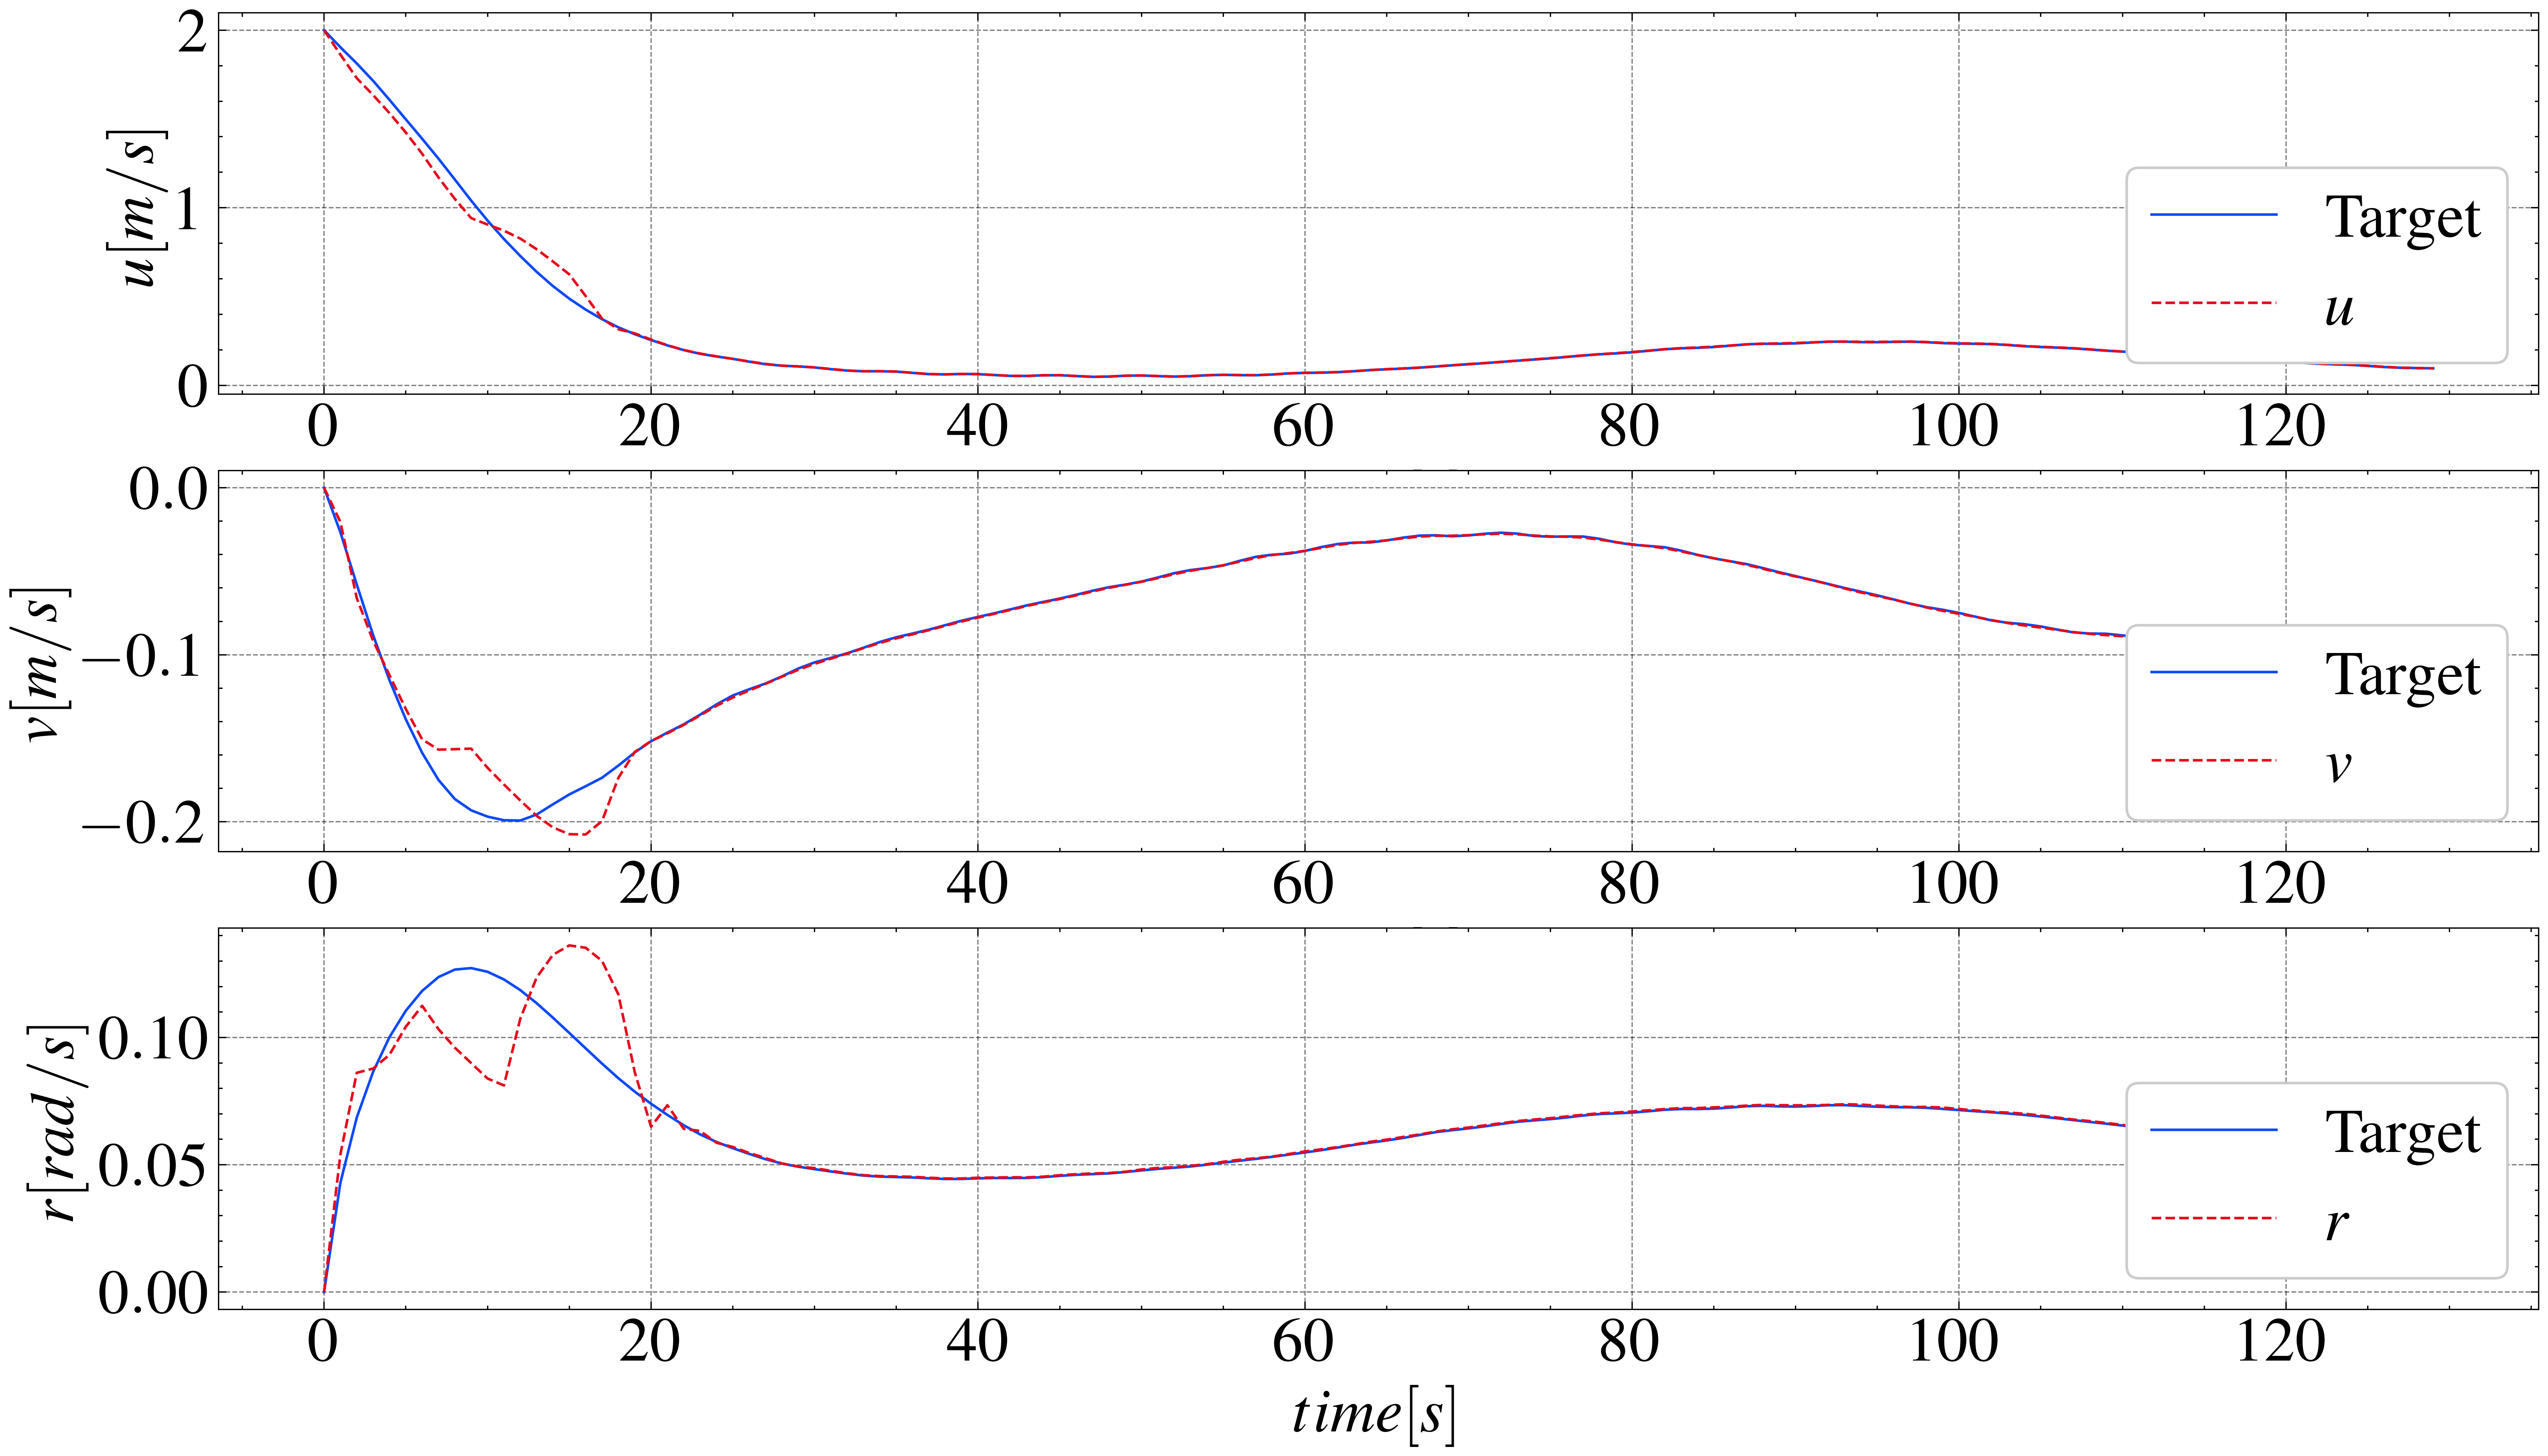

In [23]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(t_eval, u_ref, label='Target')
ax1.plot(t_eval, u, label='$u$')
ax1.set_xlabel('$t_eval[s]$', fontsize=24)
ax1.set_ylabel('$u[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax1.set_xlim([0, 100])
ax1.legend(frameon=True, loc='lower right', fontsize=24)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(t_eval, v_ref, label='Target')
ax2.plot(t_eval, v, label='$v$')
ax2.set_xlabel('$t_eval[s]$', fontsize=24)
ax2.set_ylabel('$v[m/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax2.set_xlim([0, 100])
ax2.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(t_eval, r_ref, label='Target')
ax3.plot(t_eval, r, label='$r$')
ax3.set_xlabel('$time[s]$', fontsize=24)
ax3.set_ylabel('$r[rad/s]$', fontsize=24)
plt.tick_params(labelsize=24)
# ax3.set_xlim([0, 100])
ax3.legend(frameon=True, loc='lower right', fontsize=24)
fig.show()

### 外力結果の保存

In [26]:
df = pd.DataFrame({'time':t_eval, 'X_F':X_F_Earth, 'Y_F':Y_F_Earth, 'N_F':N_F_Earth, 'psi':psi})
df.to_csv('force_obs/suzaku_1.5EF20deg_force.csv')